# Similarity

In [1]:
%run ../setup.ipynb

In this chapter, we'll develop the concepts of the **frequency domain** and the **Discrete Fourier Transform** from first principles.
The underlying idea throughout is that one can equivalently represent a signal by its sequence of sample values, or as a combination of sinusoids.
The sequence of sample values, which we've been calling $x[n]$ is known as the **time-domain** representation because the variable $n$ that we change to view the entire signal corresponds to time (sample index).
The alternate representation that we'll develop in this chapter will instead vary the **frequency** of different sinusoids, and not depend explicitly on time.

To make this all work, we'll need to develop a way to convert from the time domain to the frequency domain.
Our basic strategy will be to compare the input signal $x[n]$ to a collection of fixed reference signals.
The result of these comparisons will be a collection of similarity measurements, which (loosely speaking) measure "how much" of each reference signal is in $x[n]$.

(similarity-score)=
## Measuring similarity

One could imagine many different ways to compare two signals $x[n]$ and $y[n]$.

The definition of **similarity** that we'll use is to go sample-by-sample, multiplying $x[n] \cdot y[n]$, and summing up the results to produce a single number $S$.
In equations, this looks as follows:

$$
S(x, y) = \sum_{n=0}^{N-1} x[n] \cdot y[n]
$$

or equivalently in code:
```python
def similarity(x, y):
    '''Compute similarity between two signals x and y of the same length'''
    
    # Initialize similarity to 0
    S = 0
    
    # Accumulate the sample-wise products
    N = len(x)
    for n in range(N):
        S = S + x[n] * y[n]
        
    return S
```

The animation below provides a demonstration of this similarity calculation.
Two signals $x[n]$ (a triangle wave, top plot) and $y[n]$ (a cosine wave, center plot) with $N=32$ samples are compared by summing the sample-by-sample product ($x[n] \cdot y[n]$, bottom plot).

Each step of the loop (equivalently, term of the summation) is calculated independently, and the height of the bar on the right plot shows the running total.
When the loop is finished (we've summed all samples $n=0,1,\dots,31$), we'll have computed the total similarity $S$.

In [2]:
%%capture
# Animation of convolution

from matplotlib import gridspec

# Make an array of samples with a square wave
fs = 32

# Time sample positions
t = np.linspace(0, 1, num=fs, endpoint=False)
x = -scipy.signal.sawtooth(2 * np.pi * 2 * t, width=0.5)
y = np.cos(2 * np.pi * 2 * t)

# filter coefficients
xy = x * y

pxsum = np.cumsum(xy)

# Set up the plot skeleton
fig = plt.figure(figsize=figaspect(4./5))

gs = gridspec.GridSpec(3, 3)

ax1 = plt.subplot(gs[0:1, 0:2])
# This is the input data
p_x_orig = ax1.plot(t, x, label=r'$x[n]$', linewidth=1, marker='o',
                       markersize=10, zorder=2)

ax1.legend(ncol=2, loc='lower left')
ax1.label_outer()

ax2 = plt.subplot(gs[1:2, 0:2], sharex=ax1, sharey=ax1)

p_y_orig = ax2.plot(t, y, label=r'$y[n]$', linewidth=1, marker='o', color=colors[1],
                       markersize=10, zorder=2)

# And a label that will change

ax2.legend(ncol=2, loc='lower left')
ax2.label_outer()


ax3 = plt.subplot(gs[2:3, 0:2], sharex=ax1, sharey=ax1)

p_xy2 = ax3.plot(t, xy, linewidth=1, marker='o',
                    markersize=10, color=colors[4], zorder=0, alpha=0.25)[0]

p_xy = ax3.plot(t, xy, linewidth=1, marker='o', label=r'$x[n] \cdot y[n]$',
                   markersize=10, color=colors[4], zorder=1)[0]

p_pos = ax3.plot([0, 0], [0, 0], color=colors[8])[0]

k = 0


ax3.set_xlabel('Time [seconds]')
ax3.label_outer()
ax3.legend(loc='lower left')
ax3.set_ylim([-1.1, 1.1])

ax4 = plt.subplot(gs[1:3, 2])
p_S = ax4.bar(np.arange(1), [0], color=colors[4], label='$S$', alpha=0.75,
                linewidth=2, edgecolor=colors[4])
ax4.xaxis.set(ticks=[])
ax4.yaxis.tick_right()
ax4.set_ylim([-15, 15])
ax4.set_xlim([-1, 1])

leg = ax4.legend(loc='lower left')

eqbox = ax4.text(-0.05, 1.05, r'$$S \approx \sum_{n=0}^{' + str(k) + r'}x[n] \cdot y[n]$$',
                    va='bottom', transform=ax4.transAxes)

##--
## Animation code
# Animation frame rate
frame_rate = 24

# 1 second start pause + 2 second end-pause + 0.5 seconds per sample
anim_speed = 2
n_frames = int((1 + 2) * frame_rate + len(x) * frame_rate // anim_speed)

def init():
    return tuple([p_xy, p_pos, eqbox, leg] + list(p_S))

def sim_animate(rel_time, k, p_xy, p_pos, eqbox, leg, p_S):
    # 1s x->x[-k]  (shift)
    # 1s x[-k] -> h[k] * x[-k] (scale)
    # 0.5s pause
    # 1s scaled shift -> accumulate into y
    # 0.5s pause
    
    if k < len(x)-1:
        end_k = k+1
    else:
        end_k = len(x)-1
        
    if rel_time == 0 and k == 0:
        p_pos.set_data([t[k], t[k]], [0, xy[k]])
        p_xy.set_data(t, xy)
        for _, b in enumerate(p_S):
            b.set_height(pxsum[0])

    pause_time = 1./3
    if rel_time * anim_speed <= 1 - pause_time:
        alpha = 1 - (rel_time * anim_speed / (1 - pause_time)) **0.5
        
        xpos = t[k] * alpha + t[end_k] * (1-alpha)
        ypos = xy[k] * alpha + xy[end_k] * (1-alpha)
        p_pos.set_data([xpos, xpos], [0, ypos])
    
        # Also change data of p_xy
        for _, b in enumerate(p_S):
            b.set_height(pxsum[k] * alpha + pxsum[end_k] *(1-alpha))
        
        p_xy.set_data(t[end_k:], xy[end_k:])
        
    else:
        # This animation doesn't work
        leg.texts[0].set_text(r'$S\approx{:.2f}$'.format(pxsum[end_k]))
        eqbox.set_text(r'$$S \approx \sum_{n=0}^{' + str(end_k) + r'}x[n] \cdot y[n]$$')
        
# This is all badly broken
def animate(time):
    # infer k
    # time 1 => 0
    # time 0.5
    # time 2 => 2-1 * 2 = 2
    
    k = int((time - 1) * anim_speed)
    
    if time < 1:
        # Start with a 1s pause
        p_pos.set_data([t[k], t[k]], [0, xy[k]])
        for _, b in enumerate(p_S):
            b.set_height(pxsum[0])
        
    elif time >= n_frames / frame_rate - 2:
        # pause, do nothing
        leg.texts[0].set_text(r'$S={:.2f}$'.format(pxsum[-1]))
        eqbox.set_text(r'$$S = \sum_{n=0}^{' + str(len(xy)-1) + r'}x[n] \cdot y[n]$$')
        pass
    else:
        sim_animate(time - 1 - k / anim_speed, k, p_xy, p_pos, eqbox, leg, p_S)

    return tuple([p_xy, p_xy2, p_pos, eqbox, leg] + list(p_S))

animation = FuncAnimation(fig, animate, init_func=init,
                               frames=np.arange(n_frames, dtype=float)/frame_rate,
                               interval=1000./frame_rate, blit=True);
glue('similarity', animation, display=False)

In [3]:
animation

```{glue:figure} similarity

Similarity between signals $x$ and $y$ is computed by summing the element-wise product of their samples $x[n] \cdot y[n]$.
```

This process might feel a bit like convolution, and the equations do look similar and involve many of the same ingredients.
However, there are some key differences:

1. Convolution can be computed between any two signals.  Similarity is only defined for two signals of exactly the same length.
2. Convolution involves shifting (delaying) one signal several times to produce the output.  Similarity does not use shifting.
3. Convolution produces an output *signal* of multiple samples.  Similarity produces a single number.

## Interpreting similarity

Note that the values of $x[n]$ and $y[n]$ can be either positive or negative, and as a result, so can the similarity value $S(x, y)$.
To build some intuition for how this similarity behaves, it can be helpful to imagine situations which could lead to different values of $S$: large positive, large negative, or near zero.

Whenever the signs of $x[n]$ and $y[n]$ agree, the contribution to the total sum $S$ is positive.
If this happens often (over many sample indices $n$), then $S$ will consist primarily of positive contributions, and therefore be a large positive number.
This is the case in the example above, where the signs of the two signals are generally in agreement, leading to the high similarity score.

Likewise, when the signs disagree (e.g., $x[n] > 0 > y[n]$), the contribution to the sum is negative.
Again, if this happens often, then $S$ will consist primarily of negative contributions, and be a large negative number.

If neither of these situations occur, then the signs of $x[n]$ and $y[n]$ agree and disagree comparably often.
The positive and negative contributions will be (approximately) balanced, so the total $S$ will be near zero.

An example of each of these three cases is demonstrated in the figure below.
It's important to remember that these cases are meant as qualitative examples, and the behavior of $S$ will depend also on the *magnitude* of the sample values, not just their signs.

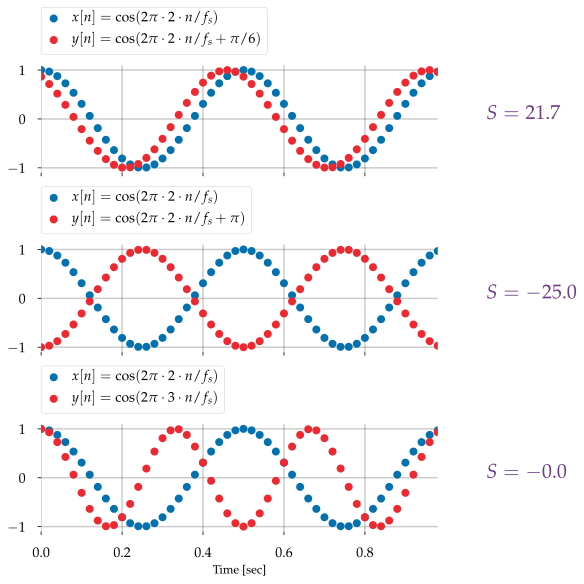

In [4]:
fs = 50

n = np.arange(fs)

f0 = 2
p0 = 0

f1 = 2
p1 = np.pi / 6

f2 = 2
p2 = np.pi

f3 = 3
p3 = 0



fig, axes = plt.subplots(nrows=3, sharex=True, sharey=True)

x0 = np.cos(2 * np.pi * f0 * n / fs + p0)
y0 = np.cos(2 * np.pi * f1 * n / fs + p1)
sim0 = np.around(np.dot(x0, y0), decimals=1)
axes[0].plot(n/fs, np.cos(2 * np.pi * f0 * n / fs + p0), marker='.', linestyle='', label=r'$x[n] = \cos(2\pi \cdot 2 \cdot n / f_s)$')
axes[0].plot(n/fs, np.cos(2 * np.pi * f1 * n / fs + p1), marker='.', linestyle='', label=r'$y[n] = \cos(2\pi \cdot 2 \cdot n / f_s + \pi / 6)$')
axes[0].legend(loc='lower left', bbox_to_anchor=(0, 1.1), borderaxespad=0.)
axes[0].text(1.1, 0.0, f'$S={sim0:.1f}$', size=20, color=colors[4])

x1 = np.cos(2 * np.pi * f0 * n / fs + p0)
y1 = np.cos(2 * np.pi * f2 * n / fs + p2)
sim1 = np.around(np.dot(x1, y1), decimals=1)
axes[1].plot(n/fs, np.cos(2 * np.pi * f0 * n / fs + p0), marker='.', linestyle='', label=r'$x[n] = \cos(2\pi \cdot 2 \cdot n / f_s)$')
axes[1].plot(n/fs, np.cos(2 * np.pi * f2 * n / fs + p2), marker='.', linestyle='', label=r'$y[n] = \cos(2\pi \cdot 2 \cdot n / f_s + \pi)$')
axes[1].legend(loc='lower left', bbox_to_anchor=(0, 1.1), borderaxespad=0.)
axes[1].text(1.1, 0.0, f'$S={sim1:.1f}$', size=20, color=colors[4])

x1 = np.cos(2 * np.pi * f0 * n / fs + p0)
y2 = np.cos(2 * np.pi * f3 * n / fs - p3)
sim2 = np.round(np.dot(x1, y2), decimals=1)
axes[2].plot(n/fs, np.cos(2 * np.pi * f0 * n / fs + p0), marker='.', linestyle='', label=r'$x[n] = \cos(2\pi \cdot 2 \cdot n / f_s)$')
axes[2].plot(n/fs, np.cos(2 * np.pi * f3 * n / fs + p3), marker='.', linestyle='', label=r'$y[n] = \cos(2\pi \cdot 3 \cdot n / f_s)$')
#axes[2].legend(loc='lower left', bbox_to_anchor=(1.05, 0), borderaxespad=0.)
axes[2].legend(loc='lower left', bbox_to_anchor=(0, 1.1), borderaxespad=0.)
axes[2].text(1.1, 0.0, f'$S={sim2:.1f}$', size=20, color=colors[4])

axes[2].set(xlabel='Time [sec]');
glue('examples', fig, display=False)

```{glue:figure} examples

Top: two waves of the same frequency and small phase difference produce a high similarity score $S=21.7$.
Middle: two waves with maximal phase difference ($pi$) produce a minimal similarity score $S=-25.0$.
Bottom: two waves of different frequency produce a similarity score of 0.
```

## Summary

The definition of similarity that we've seen here can be applied to any pair of signals $x$ and $y$, as long as they have the same length.

In the context of the Fourier transform, we're given a signal $x$, and the transform will be defined by the similarity scores produced by comparing $x$ to a collection of signals.
Our next step is to determine what that collection will be.